In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

In [2]:
model="deepseek-r1-distill-llama-70b"

### Load the model

In [3]:
from langchain_groq import ChatGroq


In [4]:
llm=ChatGroq(model_name=model)

In [5]:
llm.invoke("hi")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 4, 'total_tokens': 20, 'completion_time': 0.081087389, 'prompt_time': 6.8369e-05, 'queue_time': 0.054155451, 'total_time': 0.081155758}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--2acb1230-01ab-4627-8635-a7098b008a3b-0', usage_metadata={'input_tokens': 4, 'output_tokens': 16, 'total_tokens': 20})

In [6]:
print(llm.invoke("hi").content)

<think>

</think>

Hello! How can I assist you today? 😊


In [7]:
%pip install --upgrade langgraph


In [8]:
# import operator
# from typing import List
# from langgraph.graph.message import add_messages
# from pydantic import BaseModel , Field
# from typing import TypedDict, Annotated, Sequence
# from langchain_core.messages import BaseMessage
# from langchain_core.output_parsers import StrOutputParser
# from langchain_core.prompts import ChatPromptTemplate, PromptTemplate

from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode

In [9]:
import langgraph.prebuilt as prebuilt
print(dir(prebuilt))


['InjectedState', 'InjectedStore', 'ToolNode', 'ValidationNode', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'chat_agent_executor', 'create_react_agent', 'tool_node', 'tool_validator', 'tools_condition']


In [10]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

### this code is only for the testing/

In [11]:

state={"messages":["hi hello how are you?"]}
call_model(state)

{'messages': [AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.223744594, 'prompt_time': 0.00021768, 'queue_time': 0.05965148, 'total_time': 0.223962274}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_78afca88a5', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--d3d444b8-f1fb-4264-80d2-574641b183ef-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})]}

## Design a simple workflow without tool calling/

In [12]:
workflow=StateGraph(MessagesState)

In [13]:
workflow.add_node("mybot",call_model)

In [14]:
workflow.add_edge(START,"mybot")

In [15]:
workflow.add_edge("mybot",END)

In [16]:
app=workflow.compile()

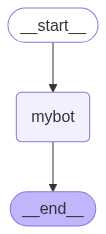

In [17]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [18]:
input={"messages":["hi hello how are you?"]}

In [19]:
app.invoke(input)

{'messages': [HumanMessage(content='hi hello how are you?', additional_kwargs={}, response_metadata={}, id='84727cda-7f62-45ec-9aa1-9d8af34f16c8'),
  AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are *you* doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 9, 'total_tokens': 53, 'completion_time': 0.191921172, 'prompt_time': 0.00020345, 'queue_time': 0.059586719999999996, 'total_time': 0.192124622}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_78afca88a5', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--6b4a47c4-5043-4dc5-9502-04c0fce51a02-0', usage_metadata={'input_tokens': 9, 'output_tokens': 44, 'total_tokens': 53})]}

In [20]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from mybot Node
_______
{'messages': [AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are *you* doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 9, 'total_tokens': 53, 'completion_time': 0.184242378, 'prompt_time': 0.002527948, 'queue_time': 0.059609181, 'total_time': 0.186770326}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_78afca88a5', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--d78e73ed-10cb-43d7-92f1-e571e4e04ef2-0', usage_metadata={'input_tokens': 9, 'output_tokens': 44, 'total_tokens': 53})]}




### this is a workflow with tool calling

In [21]:
@tool
def search(query:str):
    """this is my custom tool for searching a weather"""
    if "delhi" in query.lower():
        return "the temp is 45 degree and sunny"
    return "the temp is 25 degree and cloudy"

## testing a tool

In [22]:
search.invoke("what is a tempurature in kashmir?")

'the temp is 25 degree and cloudy'

In [23]:
search.invoke("what is a tempurature in delhi?")

'the temp is 45 degree and sunny'

In [24]:
search

StructuredTool(name='search', description='this is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001D3405076D0>)

In [25]:
llm.invoke("what is a weather in delhi?")

AIMessage(content="<think>\n\n</think>\n\nAs of my last update in July 2024, I cannot provide real-time weather information. However, Delhi generally experiences a humid subtropical climate with extreme variations in temperature throughout the year. Here's a breakdown of Delhi's typical weather:\n\n- **Summer (March to June):** Extremely hot with temperatures often reaching 45°C (113°F) or higher.\n- **Monsoon (July to September):** Hot and humid with frequent rains. The temperature ranges from 25°C to 35°C (77°F to 95°F).\n- **Winter (December to February):** Cool to cold with temperatures ranging from 2°C to 15°C (36°F to 59°F). Fog is common during this season.\n- **Autumn (October to November) and Spring (February to March):** Mild and pleasant with temperatures between 10°C to 25°C (50°F to 77°F).\n\nFor the most current weather conditions, enable live updates or check a reliable weather service.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 207, 

### Binding a tool to the LLM

### Special Note: use some good for agentic workflow since opensource model might not give you the correct output

In [26]:
tools=[search]

In [27]:
llm_with_tool=llm.bind_tools(tools)

### testig my llm_with_tool

In [28]:
response=llm_with_tool.invoke("what is a weather is delhi?")
response

AIMessage(content='', additional_kwargs={'reasoning_content': 'Alright, the user is asking about the weather in Delhi. They probably need real-time or current weather information. I should use the search tool I have to look up the weather data. Let me structure the function call with "Delhi weather" as the query.\n', 'tool_calls': [{'id': 'zmr3p9hgy', 'function': {'arguments': '{"query":"Delhi weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 133, 'total_tokens': 211, 'completion_time': 0.347550255, 'prompt_time': 0.008559059, 'queue_time': 0.066725061, 'total_time': 0.356109314}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--990c282e-6b3e-4aaf-b00b-562597f1f985-0', tool_calls=[{'name': 'search', 'args': {'query': 'Delhi weather'}, 'id': 'zmr3p9hgy', 'type': 'tool_call'}], usage_m

In [29]:
response.content

''

In [30]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'Delhi weather'},
  'id': 'zmr3p9hgy',
  'type': 'tool_call'}]

In [31]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}

### Testing code/

In [32]:
input={"messages":["what is a weather in delhi?"]}

In [33]:
response=call_model(input)

In [34]:
response["messages"][-1].content

''

In [35]:
response["messages"][-1].tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': 'v3023v781',
  'type': 'tool_call'}]

### here my router function

#### now whatever will come from call_model router funtion will redirect this to the appropriate tool

In [36]:
def router_function(state:MessagesState):
    message=state["messages"]
    last_message=message[-1]
    if last_message.tool_calls:
        return "tools"
    return END
    

In [37]:
tools

[StructuredTool(name='search', description='this is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001D3405076D0>)]

In [38]:
tool_node = prebuilt.ToolNode(tools)

In [39]:
from langgraph.graph import StateGraph

In [40]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search': StructuredTool(name='search', description='this is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001D3405076D0>)}, tool_to_state_args={'search': {}}, tool_to_store_arg={'search': None}, handle_tool_errors=True, messages_key='messages')

In [41]:
workflow2=StateGraph(MessagesState)

In [42]:
workflow2.add_node("llmwithtool",call_model)

workflow2.add_node("mytools",tool_node)

workflow2.add_edge(START,"llmwithtool")

workflow2.add_conditional_edges("llmwithtool",
                                router_function,
                                {"tools":"mytools",
                                 END:END})

In [43]:
app2=workflow2.compile()

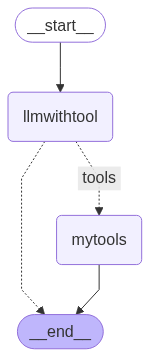

In [44]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [45]:
response=app2.invoke({"messages":["what is a weather in bengraluru?"]})

In [46]:
response["messages"][-1].content

'the temp is 25 degree and cloudy'

In [47]:
app2.invoke({"messages":["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='32e24e44-d9e0-461e-af3a-5d51b0f2b077'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about the weather in Delhi. I need to provide them with the current weather information. Since I don\'t have real-time data, I should use the tool I have available. \n\nI remember the tool is called "search" and it\'s for weather searching. It requires a query parameter. So, I should structure the function call with the name "search" and the arguments as "query" with the value "weather in Delhi".\n\nI need to make sure the JSON is correctly formatted. Let me check the parameters again: the tool expects a query string, so the arguments should be {"query": "weather in Delhi"}. \n\nPutting it all together, the function call should be wrapped in the <tool_call> tags with the name and arguments properly set.\n', 'tool_calls': [{'id': '1q7hegman', 'fun

In [48]:
app2.invoke({"messages":["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='3d851283-010d-4dea-ba17-05f3a6c79eff'),
  AIMessage(content='Thank you for your greeting! How can I assist you today?', additional_kwargs={'reasoning_content': 'Okay, the user greeted me with "hi how are you?" which is a friendly opener. I need to respond in a way that\'s both polite and helpful. Since I\'m an AI, I don\'t have feelings, but I can acknowledge their greeting.\n\nI should thank them for their greeting and offer my assistance. It\'s important to keep the tone warm and approachable. I\'ll let them know I\'m here to help with whatever they need.\n\nI don\'t see any specific request in their message, so I\'ll invite them to ask anything they want assistance with. This encourages them to engage further.\n\nI should avoid using any markdown and keep the response natural. Also, since the user included an emoji, I\'ll mirror that friendliness without overdoing it.\n\nSo, I\'ll c

In [49]:
workflow2.add_edge("mytools","llmwithtool")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [50]:
app3=workflow2.compile()

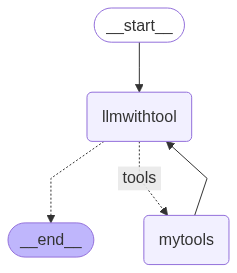

In [51]:
from IPython.display import Image, display
display(Image(app3.get_graph().draw_mermaid_png()))

In [52]:
for output in app3.stream({"messages":["what is a weather in new delhi?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")
    

here is output from llmwithtool
_______
{'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': 'Alright, so the user is asking about the weather in New Delhi. I need to figure out the best way to help them with the tools I have. I remember that I have a function called "search" which is specifically for looking up weather information. The function requires a query parameter, which is a string.\n\nFirst, I should structure the query properly. Since the user is asking about New Delhi, I should format it as "weather in New Delhi". That makes sense because it\'s clear and specific. I don\'t think I need to add anything else because the function is designed to handle such queries.\n\nNext, I need to format the tool call correctly. The function name is "search", and the arguments should be a JSON object with the query parameter. So, I\'ll set the arguments to {"query": "weather in New Delhi"}. I have to make sure the syntax is correct, with proper braces and quotation ma

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [53]:
from langgraph.checkpoint.memory import MemorySaver

In [54]:
memory=MemorySaver()

In [55]:
workflow3=StateGraph(MessagesState)

workflow3.add_node("llmwithtool",call_model)

workflow3.add_node("mytools",tool_node)

workflow3.add_edge(START,"llmwithtool")

workflow3.add_conditional_edges("llmwithtool",
                                router_function,
                                {"tools":"mytools",
                                 END:END})

workflow3.add_edge("mytools","llmwithtool")

In [56]:
app4=workflow3.compile(checkpointer=memory)

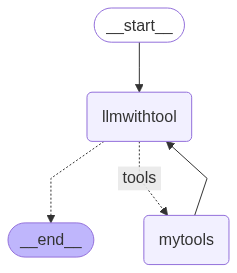

In [57]:
from IPython.display import Image, display
display(Image(app4.get_graph().draw_mermaid_png()))

In [58]:
config={"configurable": {"thread_id": "1"}}

In [59]:
events=app4.stream(
    {"messages":["what is a weather in new delhi?"]},config=config,stream_mode="values"
    )

In [60]:
for event in events:
    event["messages"][-1].pretty_print()
    

================================ Human Message =================================

what is a weather in new delhi?
================================== Ai Message ==================================
Tool Calls:
  search (v2267zx4p)
 Call ID: v2267zx4p
  Args:
    query: weather in New Delhi
================================= Tool Message =================================
Name: search

the temp is 45 degree and sunny
================================== Ai Message ==================================

The weather in New Delhi is currently 45 degrees and sunny.


In [61]:
events=app4.stream(
    {"messages":["what is a weather in indore?"]},config=config,stream_mode="values"
    )

In [62]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather in indore?
================================== Ai Message ==================================
Tool Calls:
  search (vvhaxmspx)
 Call ID: vvhaxmspx
  Args:
    query: weather in Indore
================================= Tool Message =================================
Name: search

the temp is 25 degree and cloudy
================================== Ai Message ==================================

The weather in Indore is currently 25 degrees and cloudy.


In [63]:
for event in events:
    event["messages"][-1].pretty_print()

In [64]:
config

{'configurable': {'thread_id': '1'}}

In [65]:
memory.get(config)

{'v': 4,
 'ts': '2025-07-16T05:04:49.416430+00:00',
 'id': '1f062026-64b7-694d-8008-f52b6793986d',
 'channel_versions': {'__start__': '00000000000000000000000000000007.0.9681268711453396',
  'messages': '00000000000000000000000000000010.0.9660178243468359',
  'branch:to:llmwithtool': '00000000000000000000000000000010.0.9660178243468359',
  'branch:to:mytools': '00000000000000000000000000000009.0.20431538673280203'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000006.0.7583905572752566'},
  'llmwithtool': {'branch:to:llmwithtool': '00000000000000000000000000000009.0.20431538673280203'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000008.0.644545277151781'}},
 'channel_values': {'messages': [HumanMessage(content='what is a weather in new delhi?', additional_kwargs={}, response_metadata={}, id='b9c28d17-5a66-4b0b-85be-75bafeae6cbf'),
   AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking 

In [66]:
events=app4.stream(
    {"messages":["in which city the temp was 25 degree?"]},config=config,stream_mode="values"
    )

In [67]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

in which city the temp was 25 degree?
================================== Ai Message ==================================

The city where the temperature was 25 degrees is **Indore**.


In [68]:
memory.get(config)

{'v': 4,
 'ts': '2025-07-16T05:05:28.833335+00:00',
 'id': '1f062027-dca0-6428-800b-81c18114740a',
 'channel_versions': {'__start__': '00000000000000000000000000000012.0.0011659141634500214',
  'messages': '00000000000000000000000000000013.0.4959538198687853',
  'branch:to:llmwithtool': '00000000000000000000000000000013.0.4959538198687853',
  'branch:to:mytools': '00000000000000000000000000000009.0.20431538673280203'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000011.0.48313675756940877'},
  'llmwithtool': {'branch:to:llmwithtool': '00000000000000000000000000000012.0.0011659141634500214'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000008.0.644545277151781'}},
 'channel_values': {'messages': [HumanMessage(content='what is a weather in new delhi?', additional_kwargs={}, response_metadata={}, id='b9c28d17-5a66-4b0b-85be-75bafeae6cbf'),
   AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is a